In [63]:
%matplotlib inline
import math
import re
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

from collections import defaultdict
from scipy.stats import pearsonr
import pandas as pd
from IPython.display import display

# Load calc agg features

In [64]:
DATA_DIR = r"Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data"

DATASETS = {
    "heart_diagnoses_1": "heart_diagnoses_1.csv",
    "laboratory_events_codes_2": "laboratory_events_codes_2.csv",
    "microbiology_events_codes_3": "microbiology_events_codes_3.csv",
    "procedure_code_4": "procedure_code_4.csv",
}

In [65]:
dfs = [pd.read_csv(f"{DATA_DIR}/{DATASETS[dataset].replace('.csv', '_agg_features.csv')}") for dataset in DATASETS.keys()]
len(dfs)

4

In [66]:
for df, name in zip(dfs, DATASETS.keys()):
    print(f"\nDataset: {name}")
    print("="*80)
    print(f"Shape: {df.shape}")
    print("Columns:")
    display(df.head(2))


Dataset: heart_diagnoses_1
Shape: (4864, 10)
Columns:


,subject_id,hadm_id,has_heartnotes,age,gender,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length
0,10000980,26913865,1,75.0,F,1,4,1,0.0,1058.0
1,10000980,29654838,1,75.0,F,1,3,1,0.0,770.0



Dataset: laboratory_events_codes_2
Shape: (4855, 13)
Columns:


,subject_id,hadm_id,num_labs,abnormal_ratio,qc_fail_ratio,lab_time_span_hours,unique_lab_tests,max_glucose,max_creatinine,min_hemoglobin,max_potassium,max_sodium,has_labs
0,10000980,26913865.0,166,0.0,0.024096,140.466667,45,9.0465,203.32,6.8,4.5,143.0,1
1,10000980,29654838.0,59,0.0,0.000000,33.433333,35,7.6590,123.76,8.1,4.5,146.0,1



Dataset: microbiology_events_codes_3
Shape: (2756, 7)
Columns:


,subject_id,hadm_id,has_micro,total_microbio_events,unique_specimen_types,unique_organisms,resistant_ratio
0,10000980,26913865,1,1,1,0,0.0
1,10002155,23822395,1,12,4,0,0.0



Dataset: procedure_code_4
Shape: (3459, 6)
Columns:


,subject_id,hadm_id,has_procedure,total_procedures,unique_icd_codes,procedure_span_days
0,10000980,26913865,1,7,7,0.0
1,10002013,24760295,1,2,2,0.0


# Merge

In [67]:
from functools import reduce

# Merge all on ['subject_id', 'hadm_id']
patient_profile = reduce(
    lambda left, right: pd.merge(left, right, on=['subject_id', 'hadm_id'], how='outer'),
    dfs
)

In [68]:
# Targeted NA handling
has_cols = [c for c in patient_profile.columns if c.startswith('has_')]
print(has_cols)
# Fill indicators with 0 (absent)
patient_profile[has_cols] = patient_profile[has_cols].fillna(0).astype(int)

['has_heartnotes', 'has_labs', 'has_micro', 'has_procedure']


In [69]:
# Identify numeric columns (exclude ids/flags)
numeric_cols = [c for c in patient_profile.select_dtypes(include='number').columns
                if c not in ('subject_id', 'hadm_id')]

# Heuristic: detect count-like columns and fill zeros when corresponding has_* indicates absence
count_like_keywords = ('num_', 'total_', 'unique_', 'n_', 'count', '_count')
count_cols = [c for c in numeric_cols if any(k in c for k in count_like_keywords)]

In [70]:
# mapping heuristics from feature name -> has_ flag (extend if needed)
map_keywords = {
    'lab': 'has_labs',
    'micro': 'has_micro',
    'procedure': 'has_procedure',
    'proc': 'has_procedure',
    'note': 'has_heartnotes',
    'imaging': 'has_imaging'  # if you ever create has_imaging
}

for col in count_cols:
    filled = False
    lname = col.lower()
    for key, has_flag in map_keywords.items():
        if key in lname and has_flag in patient_profile.columns:
            patient_profile.loc[patient_profile[has_flag] == 0, col] = 0
            filled = True
            break
    if not filled:
        # safe fallback: fill remaining NaNs with 0 (counts mean absence)
        patient_profile[col] = patient_profile[col].fillna(0)

# Measurements / statistics: keep NaN but create missing indicators
exclude_from_measure = set(count_cols) | set(has_cols) | {'subject_id', 'hadm_id'}
measurement_cols = [c for c in numeric_cols if c not in exclude_from_measure and c != 'is_dead']

for c in measurement_cols:
    patient_profile[c + '_missing'] = patient_profile[c].isna().astype(int)

In [71]:
patient_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5166 entries, 0 to 5165
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   subject_id               5166 non-null   int64  
 1   hadm_id                  5166 non-null   int64  
 2   has_heartnotes           5166 non-null   int64  
 3   age                      1363 non-null   float64
 4   gender                   4858 non-null   object 
 5   is_dead                  4864 non-null   float64
 6   num_imaging_tests        5166 non-null   float64
 7   num_unique_icd           5166 non-null   float64
 8   note_time_span_hours     5166 non-null   float64
 9   hpi_length               4864 non-null   float64
 10  num_labs                 5166 non-null   float64
 11  abnormal_ratio           4855 non-null   float64
 12  qc_fail_ratio            4855 non-null   float64
 13  lab_time_span_hours      5166 non-null   float64
 14  unique_lab_tests        

In [72]:
patient_profile.head()

,subject_id,hadm_id,has_heartnotes,age,gender,is_dead,num_imaging_tests,num_unique_icd,note_time_span_hours,hpi_length,...,procedure_span_days,age_missing,hpi_length_missing,abnormal_ratio_missing,qc_fail_ratio_missing,max_glucose_missing,max_creatinine_missing,max_potassium_missing,max_sodium_missing,resistant_ratio_missing
0,10000980,26913865,1,75.0,F,1.0,4.0,1.0,0.0,1058.0,...,0.0,0,0,0,0,0,0,0,0,0
1,10000980,29654838,1,75.0,F,1.0,3.0,1.0,0.0,770.0,...,0.0,0,0,0,0,0,0,0,0,1
2,10002013,24760295,1,NaN,F,0.0,4.0,1.0,0.0,2007.0,...,0.0,1,0,0,0,0,0,0,0,1
3,10002155,23822395,1,NaN,F,0.0,3.0,1.0,0.0,1752.0,...,14.0,1,0,0,0,0,0,0,0,0
4,10004457,28723315,1,66.0,M,0.0,3.0,1.0,0.0,1783.0,...,0.0,0,0,0,0,0,0,0,1,1


# Completeness Analysis

In [73]:
# Identify the 'has_' indicator columns
has_columns = [col for col in patient_profile.columns if col.startswith('has_')]
print(f"Data source indicators: {has_columns}")

Data source indicators: ['has_heartnotes', 'has_labs', 'has_micro', 'has_procedure']



COMPLETENESS SUMMARY

Per-Source Availability:
  has_heartnotes: 4,864 patients (94.2%)
  has_labs: 4,855 patients (94.0%)
  has_micro: 2,756 patients (53.3%)
  has_procedure: 3,459 patients (67.0%)

--------------------------------------------------------------------------------
DATA SOURCE COMBINATIONS:
--------------------------------------------------------------------------------
  [1-1-1-1] heartnotes, labs, micro, procedure: 1,932 (37.4%)
  [1-1-0-1] heartnotes, labs, procedure: 1,525 (29.5%)
  [1-1-0-0] heartnotes, labs: 876 (17.0%)
  [1-1-1-0] heartnotes, labs, micro: 522 (10.1%)
  [0-0-1-0] micro: 302 (5.8%)
  [1-0-0-0] heartnotes: 7 (0.1%)
  [1-0-0-1] heartnotes, procedure: 2 (0.0%)


C:\Users\dgars\AppData\Local\Temp\ipykernel_30916\1571333312.py:42: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(sources, rotation=45, ha='right')


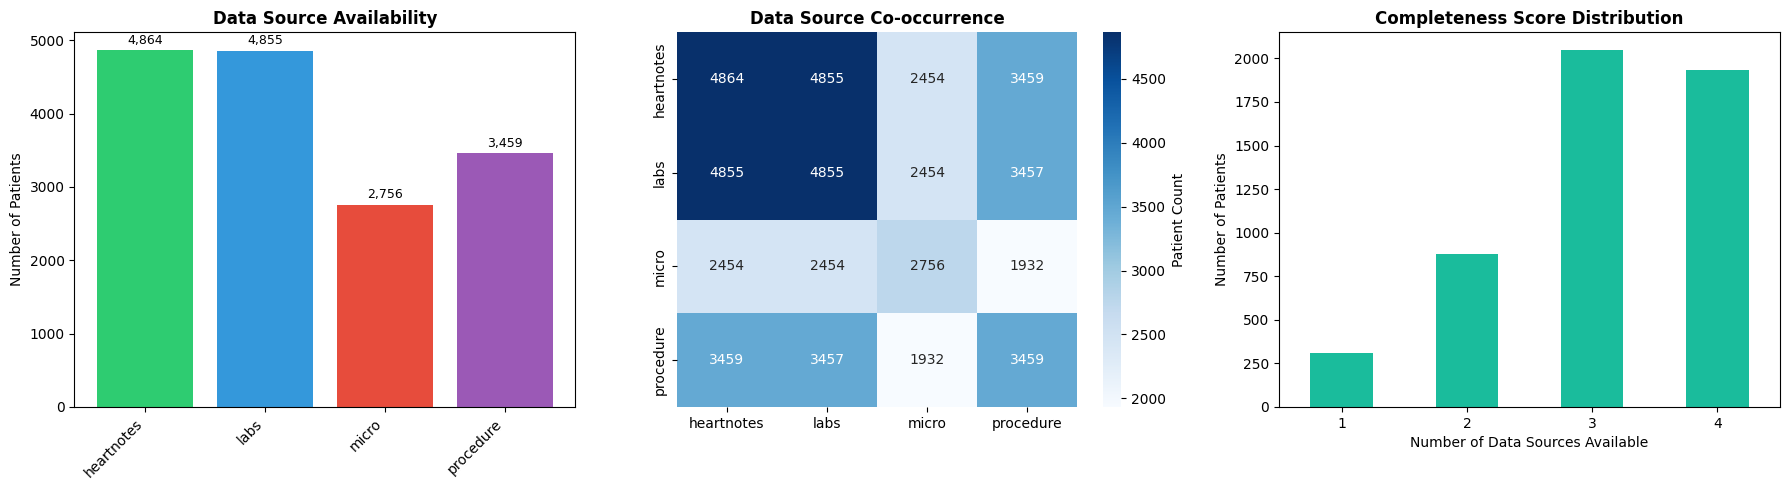


COMPLETENESS SCORE SUMMARY

Total patients: 5,166
Patients with ALL sources: 1,932
Patients with NO sources: 0
Average sources per patient: 3.08


In [74]:
# Completeness Matrix - Check which data sources are available for each patient
completeness = patient_profile[has_columns].copy()

# Summary statistics
print("\n" + "="*80)
print("COMPLETENESS SUMMARY")
print("="*80)

# Per-source completeness
print("\nPer-Source Availability:")
for col in has_columns:
    count = (patient_profile[col] == 1).sum()
    pct = count / len(patient_profile) * 100
    print(f"  {col}: {count:,} patients ({pct:.1f}%)")

# Combination completeness
print("\n" + "-"*80)
print("DATA SOURCE COMBINATIONS:")
print("-"*80)

# Create a combined key for each row
completeness['combination'] = completeness[has_columns].astype(int).astype(str).agg('-'.join, axis=1)
combo_counts = completeness['combination'].value_counts()

# Create readable labels
for combo, count in combo_counts.items():
    sources = [has_columns[i].replace('has_', '') for i, val in enumerate(combo.split('-')) if val == '1']
    sources_str = ', '.join(sources) if sources else 'None'
    pct = count / len(patient_profile) * 100
    print(f"  [{combo}] {sources_str}: {count:,} ({pct:.1f}%)")

# Visualization
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Bar chart of individual source availability
ax1 = axes[0]
source_counts = [(col.replace('has_', ''), (patient_profile[col] == 1).sum()) for col in has_columns]
sources, counts = zip(*source_counts)
bars = ax1.bar(sources, counts, color=['#2ecc71', '#3498db', '#e74c3c', '#9b59b6'][:len(has_columns)])
ax1.set_ylabel('Number of Patients')
ax1.set_title('Data Source Availability', fontweight='bold')
ax1.set_xticklabels(sources, rotation=45, ha='right')
for bar, count in zip(bars, counts):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50, 
             f'{count:,}', ha='center', va='bottom', fontsize=9)

# Plot 2: Heatmap of co-occurrence
ax2 = axes[1]
cooccurrence = pd.DataFrame(index=has_columns, columns=has_columns, dtype=float)
for col1 in has_columns:
    for col2 in has_columns:
        both = ((patient_profile[col1] == 1) & (patient_profile[col2] == 1)).sum()
        cooccurrence.loc[col1, col2] = both

# Rename for display
cooccurrence.index = [c.replace('has_', '') for c in cooccurrence.index]
cooccurrence.columns = [c.replace('has_', '') for c in cooccurrence.columns]

sns.heatmap(cooccurrence.astype(float), annot=True, fmt='.0f', cmap='Blues', 
            ax=ax2, cbar_kws={'label': 'Patient Count'})
ax2.set_title('Data Source Co-occurrence', fontweight='bold')

# Plot 3: Completeness score distribution
ax3 = axes[2]
patient_profile['completeness_score'] = patient_profile[has_columns].sum(axis=1)
patient_profile['completeness_score'].value_counts().sort_index().plot(kind='bar', ax=ax3, color='#1abc9c')
ax3.set_xlabel('Number of Data Sources Available')
ax3.set_ylabel('Number of Patients')
ax3.set_title('Completeness Score Distribution', fontweight='bold')
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)

plt.tight_layout()
plt.savefig(r'../plots/1.2_completeness_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Final summary
print("\n" + "="*80)
print("COMPLETENESS SCORE SUMMARY")
print("="*80)
print(f"\nTotal patients: {len(patient_profile):,}")
print(f"Patients with ALL sources: {(patient_profile['completeness_score'] == len(has_columns)).sum():,}")
print(f"Patients with NO sources: {(patient_profile['completeness_score'] == 0).sum():,}")
print(f"Average sources per patient: {patient_profile['completeness_score'].mean():.2f}")

# Save big patient profile

In [75]:
patient_profile.to_csv(os.path.join(DATA_DIR, "patient_profile_large.csv"), index=False)

# Corr

In [27]:
patient_profile.columns

Index(['subject_id', 'hadm_id', 'has_heartnotes', 'age', 'gender', 'is_dead',
       'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours',
       'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio',
       'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'has_labs',
       'has_micro', 'total_microbio_events', 'unique_specimen_types',
       'unique_organisms', 'resistant_ratio', 'has_procedure',
       'total_procedures', 'unique_icd_codes', 'procedure_span_days',
       'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing',
       'qc_fail_ratio_missing', 'max_glucose_missing',
       'resistant_ratio_missing'],
      dtype='object')

In [ ]:
def corr_report(df, features, data_dir=None, plot_name='selected_features_corr.png', threshold=0.60, figsize=(12,10), show_plot=True):
    """
    Compute correlation matrix for given features in df, plot heatmap, and return correlations + high-corr pairs.
    Args:
      df : pandas.DataFrame
      features : list of column names to consider (will keep only existing)
      data_dir : optional base dir to save plot (if None uses cwd)
      plot_name : filename for saved plot (saved into <data_dir>/plots/)
      threshold : float, absolute correlation threshold to report pairs
      figsize : tuple, matplotlib figure size
      show_plot : bool, whether to plt.show()
    Returns:
      corr_df : pandas.DataFrame (correlation matrix)
      high_pairs : list of tuples (col1, col2, corr_value)
      used_features : list of features actually used for numeric corr
    """
    import os
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    import pandas as pd

    # keep only existing requested cols
    sel = [c for c in features if c in df.columns]
    if not sel:
        raise ValueError("No requested features found in dataframe.")

    tmp = df[sel].copy()

    # simple encoding for common categorical used here
    if 'gender' in tmp.columns:
        tmp['gender_enc'] = tmp['gender'].map({'M':1, 'F':0}).fillna(-1)
        tmp = tmp.drop(columns=['gender'])

    # booleans -> int
    for c in tmp.columns:
        if tmp[c].dtype == 'bool':
            tmp[c] = tmp[c].astype(int)

    # select numeric columns only
    num_tmp = tmp.select_dtypes(include=[np.number]).copy()
    used_features = num_tmp.columns.tolist()
    if len(used_features) < 2:
        raise ValueError("Need at least two numeric features for correlation. Numeric found: " + ", ".join(used_features))

    # correlation
    corr_df = num_tmp.corr()

    # plot heatmap (mask upper triangle)
    plt.figure(figsize=figsize)
    mask = np.triu(np.ones_like(corr_df, dtype=bool))
    sns.heatmap(corr_df, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                cbar_kws={'label':'corr'})
    plt.title('Correlation matrix — selected features')
    plt.tight_layout()

    # save
    if data_dir is None:
        save_dir = os.path.abspath('.')
    else:
        save_dir = data_dir
    plots_dir = os.path.join(save_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)
    save_path = os.path.join(plots_dir, plot_name)
    plt.savefig(save_path, dpi=200, bbox_inches='tight')

    if show_plot:
        plt.show()
    else:
        plt.close()

    # extract high-correlation pairs (upper triangle only)
    cols = corr_df.columns.tolist()
    high_pairs = []
    for i in range(len(cols)):
        for j in range(i+1, len(cols)):
            val = corr_df.iloc[i, j]
            if pd.notna(val) and abs(val) >= threshold:
                high_pairs.append((cols[i], cols[j], float(val)))

    # print brief report
    print(f"Correlation matrix saved to: {save_path}")
    print(f"Numeric features used ({len(used_features)}): {used_features}")
    print(f"High-corr pairs (|r| >= {threshold}): {len(high_pairs)}")
    for a,b,v in sorted(high_pairs, key=lambda x: -abs(x[2])):
        print(f"  {a} <--> {b}  :  {v:.3f}")

    return corr_df, high_pairs, used_features


Selected features for correlation check: 26 ['age', 'gender', 'is_dead', 'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'unique_icd_codes', 'procedure_span_days', 'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing', 'qc_fail_ratio_missing', 'max_glucose_missing', 'resistant_ratio_missing']


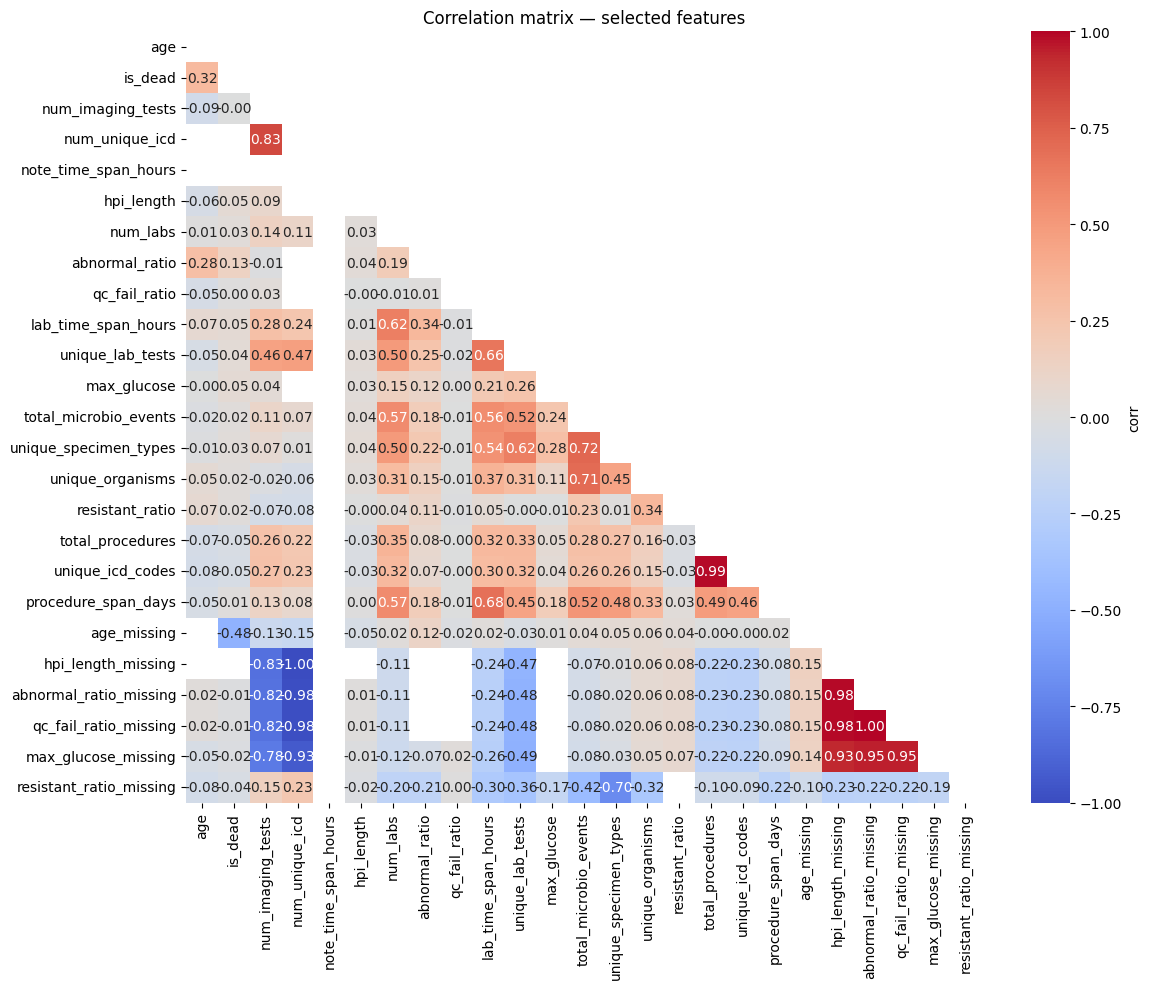

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\selected_features_corr.png
Numeric features used (25): ['age', 'is_dead', 'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'unique_icd_codes', 'procedure_span_days', 'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing', 'qc_fail_ratio_missing', 'max_glucose_missing', 'resistant_ratio_missing']
High-corr pairs (|r| >= 0.8): 15
  num_unique_icd <--> hpi_length_missing  :  -1.000
  abnormal_ratio_missing <--> qc_fail_ratio_missing  :  1.000
  total_procedures <--> unique_icd_codes  :  0.987
  num_unique_icd <--> abnormal_ratio_missing  :  -0.985
  num_unique_icd <--> qc_fail_ratio_missing  :  -0.985
  hpi_length_missing <--> abnormal_ratio_missing 

In [37]:
core_features = [
      'age', 'gender', 'is_dead',
       'num_imaging_tests', 'num_unique_icd', 'note_time_span_hours',
       'hpi_length',
       
        'num_labs', 'abnormal_ratio', 'qc_fail_ratio',
       'lab_time_span_hours', 'unique_lab_tests', 'max_glucose',
       
       'total_microbio_events', 'unique_specimen_types',
       'unique_organisms', 'resistant_ratio', 

       'total_procedures', 'unique_icd_codes', 'procedure_span_days',
       'age_missing', 'hpi_length_missing', 'abnormal_ratio_missing',
       'qc_fail_ratio_missing', 'max_glucose_missing',
       'resistant_ratio_missing'
]

# keep only existing columns
sel = [c for c in core_features if c in patient_profile.columns]
print("Selected features for correlation check:", len(sel), sel)

tmp = patient_profile[sel].copy()

# Encode non-numeric temporarily for correlation
if 'gender' in tmp.columns:
    tmp['gender_enc'] = tmp['gender'].map({'M':1, 'F':0}).fillna(-1)
    tmp = tmp.drop(columns=['gender'])

# Ensure bool/has_ are numeric
for c in tmp.columns:
    if tmp[c].dtype == 'bool':
        tmp[c] = tmp[c].astype(int)

corr_df, high_pairs, used = corr_report(tmp, sel, data_dir=DATA_DIR, threshold=0.80)

So we drop:

Selected features for correlation check: 21 ['age', 'gender', 'is_dead', 'num_imaging_tests', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'procedure_span_days', 'age_missing', 'max_glucose_missing', 'resistant_ratio_missing']


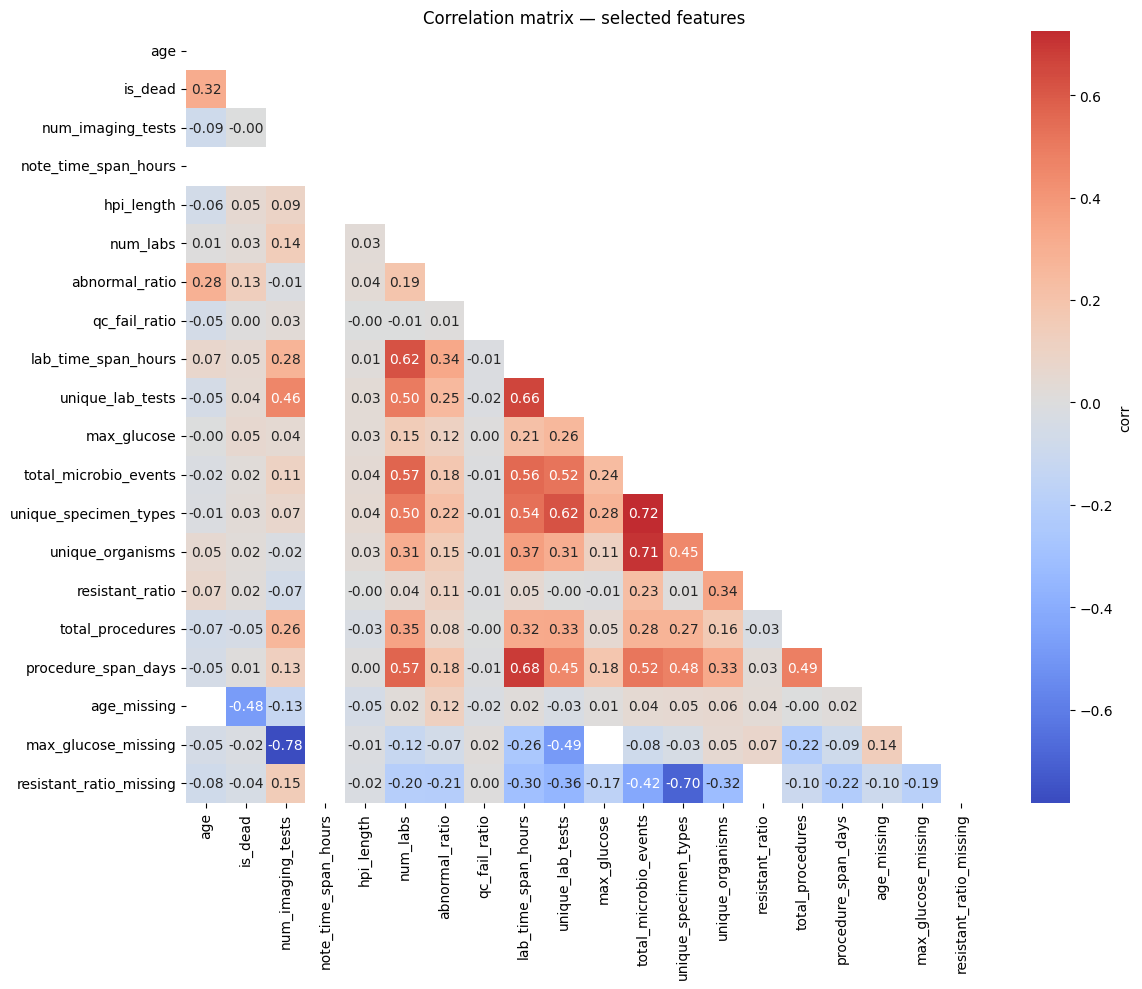

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\selected_features_corr.png
Numeric features used (20): ['age', 'is_dead', 'num_imaging_tests', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'procedure_span_days', 'age_missing', 'max_glucose_missing', 'resistant_ratio_missing']
High-corr pairs (|r| >= 0.8): 0


In [ ]:
to_drop = [
    # these are highly corr >0.8
    'num_unique_icd', 'qc_fail_ratio_missing', 'unique_icd_codes', 'hpi_length_missing', 'abnormal_ratio_missing'
    # 
]

# keep only existing columns
sel_small = [c for c in sel if c not in to_drop]
print("Selected features for correlation check:", len(sel_small), sel_small)

tmp = patient_profile[sel_small].copy()

# Encode non-numeric temporarily for correlation
if 'gender' in tmp.columns:
    tmp['gender_enc'] = tmp['gender'].map({'M':1, 'F':0}).fillna(-1)
    tmp = tmp.drop(columns=['gender'])

# Ensure bool/has_ are numeric
for c in tmp.columns:
    if tmp[c].dtype == 'bool':
        tmp[c] = tmp[c].astype(int)

corr_df, high_pairs, used = corr_report(tmp, sel_small, data_dir=DATA_DIR, threshold=0.80)

# Further select and compute combined features

Indicators (name — objective — mathematical formulation)

- clinical_activity — Objective: summarize overall care intensity (imaging, labs, micro, procedures).
Formula: clinical_activity = mean( log1p(num_imaging_tests), log1p(num_labs), log1p(total_microbio_events), log1p(total_procedures) )
- lab_abnormality_index — Objective: quantify useful lab abnormality signal adjusted for QC reliability.
Formula: lab_abnormality_index = abnormal_ratio * (1 - qc_fail_ratio) (both treated as proportions; missing → 0)
- micro_resistance_score — Objective: measure microbiology resistance burden weighted by organism/specimen diversity.
Formula: micro_resistance_score = resistant_ratio * log1p(unique_organisms + unique_specimen_types)
- history_depth — Objective: capture documentation richness / diagnostic narrative depth.
Formula: history_depth = log1p(hpi_length) + log1p(note_time_span_hours)
- procedure_density — Objective: intensity of procedures per time span (higher → more interventionist/acute).
Formula: procedure_density = total_procedures / max(1, procedure_span_days)

In [76]:
def compute_indicators_and_run_corr(df, data_dir=None, save_plots=True, corr_threshold=0.60, figsize=(10,8)):
    """
    Compute the 8 team indicators  using available max-* labs,
    add them to a copy of df, then produce correlation matrices for:
      1) indicators only
      2) indicators + all original 'core' features (if present)
      3) indicators + small old feature set ['age','n_total_admissions','is_dead','gender']
    Returns: (df_out, corr_results)
    """
    d = df.copy()

    # --- safe fills for counts / spans (absence -> 0) ---
    counts = ['num_imaging_tests', 'num_labs', 'total_microbio_events', 'total_procedures']
    for c in counts:
        if c in d.columns:
            d[c] = d[c].fillna(0)

    # --- original 5 indicators ---
    cols_for_activity = [c for c in counts if c in d.columns]
    if cols_for_activity:
        d['clinical_activity'] = np.mean([np.log1p(d[c]) for c in cols_for_activity], axis=0)

    if 'abnormal_ratio' in d.columns:
        ar = d['abnormal_ratio'].fillna(0)
        qc = d['qc_fail_ratio'].fillna(0) if 'qc_fail_ratio' in d.columns else 0
        d['lab_abnormality_index'] = ar * (1 - qc)

    if 'resistant_ratio' in d.columns:
        rr = d['resistant_ratio'].fillna(0)
        uo = d['unique_organisms'].fillna(0) if 'unique_organisms' in d.columns else 0
        us = d['unique_specimen_types'].fillna(0) if 'unique_specimen_types' in d.columns else 0
        d['micro_resistance_score'] = rr * np.log1p(uo + us)

    hl = d['hpi_length'].fillna(0) if 'hpi_length' in d.columns else 0
    nts = d['note_time_span_hours'].fillna(0) if 'note_time_span_hours' in d.columns else 0
    d['history_depth'] = np.log1p(hl) + np.log1p(nts)

    if 'total_procedures' in d.columns:
        pdays = d['procedure_span_days'].fillna(1) if 'procedure_span_days' in d.columns else 1
        d['procedure_density'] = d['total_procedures'] / pdays.clip(lower=1)

    # --- additional indicators ---
    if 'n_diagnoses' in d.columns:
        d['diagnosis_burden'] = np.log1p(d['n_diagnoses'].fillna(0))

    # --- improved metabolic_stress_index using available max labs ---
    # prefer max_creatinine if present otherwise mean_creatinine
    creat_col = None
    if 'max_creatinine' in d.columns:
        creat_col = 'max_creatinine'
    elif 'mean_creatinine' in d.columns:
        creat_col = 'mean_creatinine'

    stress_cols = []
    if 'max_glucose' in d.columns:
        stress_cols.append('max_glucose')
    if creat_col is not None:
        stress_cols.append(creat_col)

    # include electrolytes if available
    for c in ['max_potassium', 'max_sodium']:
        if c in d.columns:
            stress_cols.append(c)

    # hemoglobin: prefer nadir/min if available; use gender-specific thresholds (WHO-ish)
    if 'min_hemoglobin' in d.columns or 'max_hemoglobin' in d.columns:
        # choose best available column (min preferred because anemia is about low values)
        hb_col = 'min_hemoglobin' if 'min_hemoglobin' in d.columns else 'max_hemoglobin'

        # gender-specific anemia thresholds (adjustable)
        if 'gender' in d.columns:
            thresh = d['gender'].map({'M': 13.0, 'F': 12.0}).fillna(13.0)
        else:
            thresh = pd.Series(13.0, index=d.index)

        # fill missing hemoglobin with threshold so missing -> proxy 0 (no assumed anemia)
        hb = d[hb_col].copy()
        hb = hb.fillna(thresh)

        # proxy = relative deficit below threshold, clipped at 0
        d['hemoglobin_anemia_proxy'] = ((thresh - hb) / thresh).clip(lower=0.0)

        stress_cols.append('hemoglobin_anemia_proxy')

    if stress_cols:
        # robust scale: (x - median) / IQR  (avoids extreme influence)
        def robust_z(s):
            s = s.astype(float)
            med = s.median()
            iqr = (s.quantile(0.75) - s.quantile(0.25))
            denom = iqr if iqr > 0 else (s.std() + 1e-9)
            return (s - med) / (denom + 1e-9)

        z_vals = []
        for c in stress_cols:
            z = robust_z(d[c].fillna(d[c].median() if c in d.columns else 0))
            # use absolute deviation (both high and low deviations matter for stress)
            z_vals.append(z.abs())

        # metabolic_stress_index = mean absolute robust-z across available stress cols
        d['metabolic_stress_index'] = pd.concat(z_vals, axis=1).mean(axis=1)

    # recent admission recency score
    if 'days_since_last_admission' in d.columns:
        d['recent_admission_score'] = 1.0 / (1.0 + d['days_since_last_admission'].fillna(3650))

    # list of computed indicators that exist now
    indicators = [c for c in [
        'clinical_activity','lab_abnormality_index','micro_resistance_score',
        'history_depth','procedure_density',
        'diagnosis_burden','metabolic_stress_index','recent_admission_score'
    ] if c in d.columns]

    print("Computed indicators:", indicators)

    # --- prepare old/core features ---
    core_features_local = [
        'age','gender','is_dead',
        'num_imaging_tests','note_time_span_hours','hpi_length',
        'num_labs','abnormal_ratio','qc_fail_ratio','lab_time_span_hours','unique_lab_tests','max_glucose',
        'total_microbio_events','unique_specimen_types','unique_organisms','resistant_ratio',
        'total_procedures','procedure_span_days','n_diagnoses', creat_col, 'days_since_last_admission','n_total_admissions'
    ]
    # keep only existing
    old_all = [c for c in core_features_local if c in d.columns]

    small_old = [c for c in ['age','n_total_admissions','is_dead','gender'] if c in d.columns]

    # where to save plots
    save_dir = os.path.abspath('.') if data_dir is None else data_dir
    plots_dir = os.path.join(save_dir, 'plots')
    os.makedirs(plots_dir, exist_ok=True)

    corr_results = {}

    # 1) indicators only
    name = 'indicators_only'
    print(f"\nRunning correlation: {name}")
    corr_results[name] = corr_report(d, indicators, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                    threshold=corr_threshold, figsize=figsize, show_plot=save_plots)

    # 2) indicators + all old/core features
    name = 'indicators_plus_old_all'
    features_combo = indicators + old_all
    features_combo = [c for c in features_combo if c in d.columns]
    if len(features_combo) >= 2:
        print(f"\nRunning correlation: {name} (n_features={len(features_combo)})")
        corr_results[name] = corr_report(d, features_combo, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                        threshold=corr_threshold, figsize=figsize, show_plot=save_plots)
    else:
        corr_results[name] = (None, [], [])

    # 3) indicators + small_old (user requested)
    name = 'indicators_plus_small_old'
    features_combo2 = indicators + small_old
    features_combo2 = [c for c in features_combo2 if c in d.columns]
    if len(features_combo2) >= 2:
        print(f"\nRunning correlation: {name} (n_features={len(features_combo2)})")
        corr_results[name] = corr_report(d, features_combo2, data_dir=save_dir, plot_name=f'{name}_corr.png',
                                        threshold=corr_threshold, figsize=figsize, show_plot=save_plots)
    else:
        corr_results[name] = (None, [], [])

    return d, corr_results

Computed indicators: ['clinical_activity', 'lab_abnormality_index', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index']

Running correlation: indicators_only


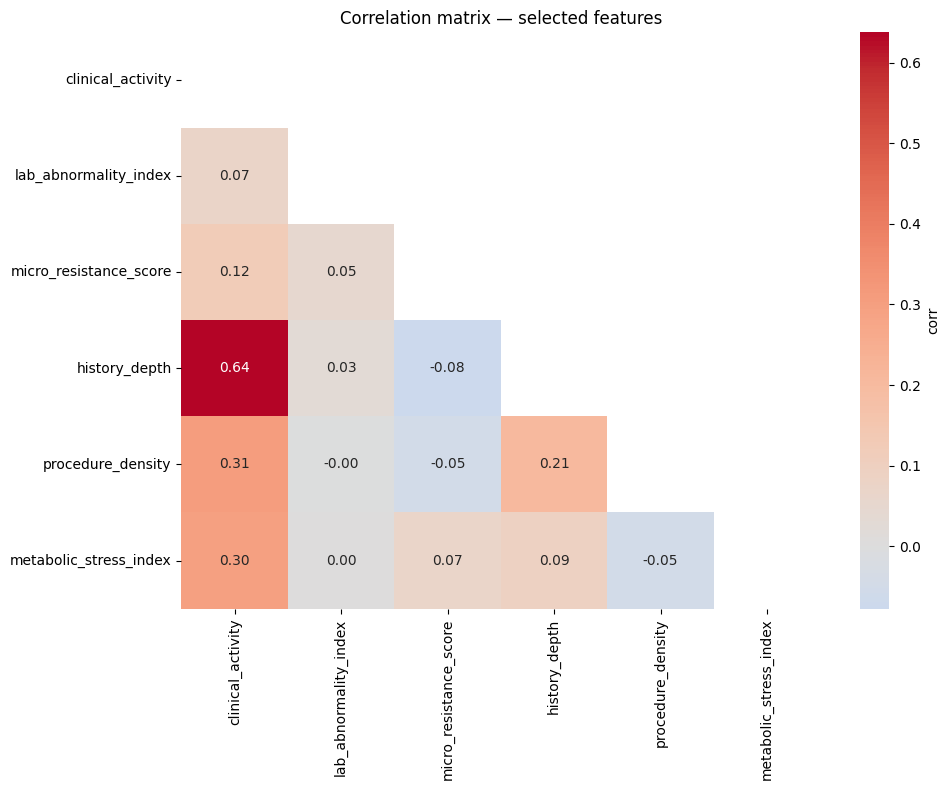

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_only_corr.png
Numeric features used (6): ['clinical_activity', 'lab_abnormality_index', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index']
High-corr pairs (|r| >= 0.6): 1
  clinical_activity <--> history_depth  :  0.638

Running correlation: indicators_plus_old_all (n_features=25)


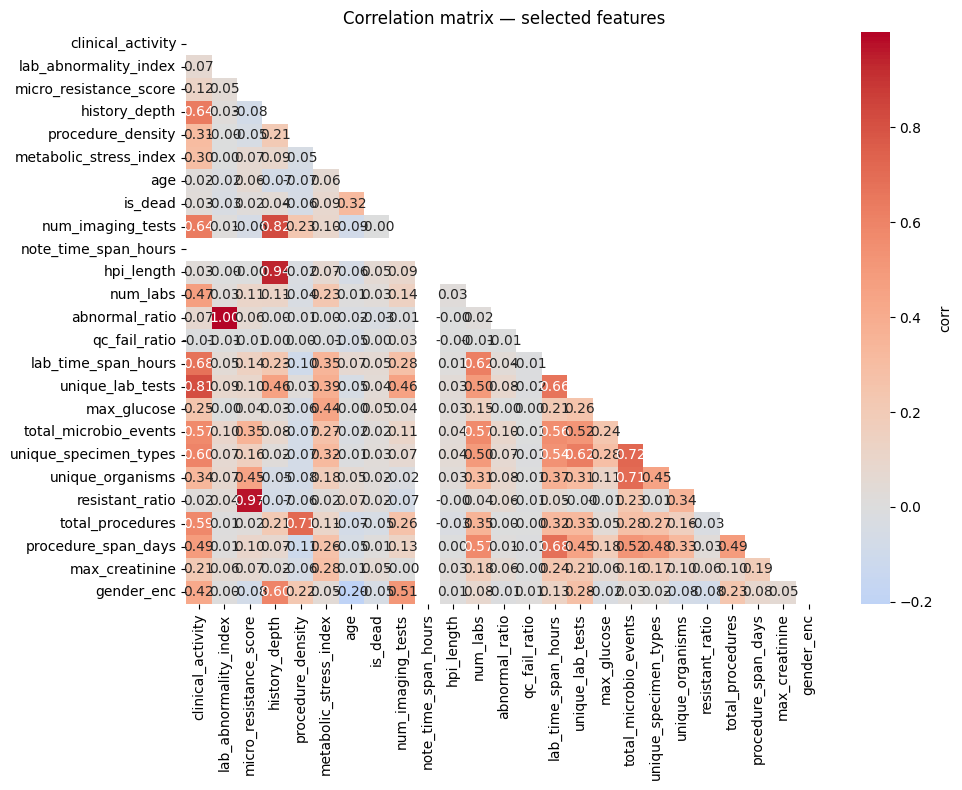

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_plus_old_all_corr.png
Numeric features used (25): ['clinical_activity', 'lab_abnormality_index', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'age', 'is_dead', 'num_imaging_tests', 'note_time_span_hours', 'hpi_length', 'num_labs', 'abnormal_ratio', 'qc_fail_ratio', 'lab_time_span_hours', 'unique_lab_tests', 'max_glucose', 'total_microbio_events', 'unique_specimen_types', 'unique_organisms', 'resistant_ratio', 'total_procedures', 'procedure_span_days', 'max_creatinine', 'gender_enc']
High-corr pairs (|r| >= 0.6): 15
  lab_abnormality_index <--> abnormal_ratio  :  1.000
  micro_resistance_score <--> resistant_ratio  :  0.973
  history_depth <--> hpi_length  :  0.938
  history_depth <--> num_imaging_tests  :  0.822
  clinical_activity <--> unique_lab_tests  :  0.812
  total_microbio_events <--> unique_specimen_types  :  0.725
  procedure_d

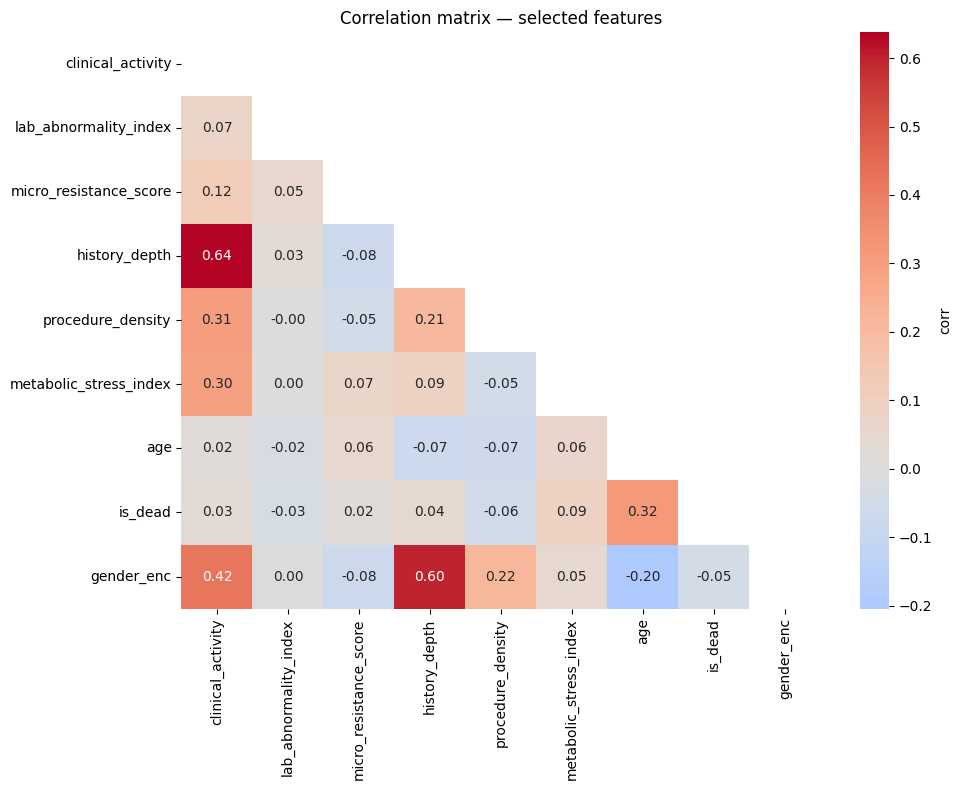

Correlation matrix saved to: Y:\Studium\3. Sem UniPI\Data Analytics 4 digital Health\Data\plots\indicators_plus_small_old_corr.png
Numeric features used (9): ['clinical_activity', 'lab_abnormality_index', 'micro_resistance_score', 'history_depth', 'procedure_density', 'metabolic_stress_index', 'age', 'is_dead', 'gender_enc']
High-corr pairs (|r| >= 0.6): 1
  clinical_activity <--> history_depth  :  0.638


In [77]:
patient_profile_new, corr_res = compute_indicators_and_run_corr(patient_profile, data_dir=DATA_DIR, save_plots=True)

patient_profile_new.info()

# Reduce patient profile based on corr

In [ ]:
sel_small = [
    'subject_id', 'hadm_id', 
    
]

In [ ]:
patient_profile_small = patient_profile_new[  + sel_small].copy()
patient_profile_small.info()


# Save to csv

In [ ]:
patient_profile_small.to_csv(os.path.join(DATA_DIR, "patient_profile_small.csv"), index=False)

In [ ]:
# For clustering: create an imputed, encoded and scaled version 
# ecnode gender 
# Impute measurement columns with median (but keep _missing flags) imputer = SimpleImputer(strategy='median')
# Select features for clustering:
# - counts and unique (already 0 where appropriate)
# - has_ indicators
# - measurement columns (median-imputed)
# - missing indicators
# - encoded gender (optional)

In [ ]:
# # Short suggestions (printed)
# print("\nNext steps (brief):")
# print(" - Remove or aggregate very highly correlated features (see pairs above).")
# print(" - Keep has_* flags; create missingness indicators for measurements before imputation.")
# print(" - In clustering notebook: impute measurements (median), encode categorical (gender), scale (RobustScaler),")
# print("   optionally reduce dim (PCA/UMAP) and evaluate clusters (silhouette, stability).")